# Capstone Project - The Battle of Neighbourhoods

The scope of the project to use Foursquare API and Machine Learing algorithm to analyse the city of Liverpool with respect to establishing a business from small and medium scale enterpruer and also to guide tourist visiting UK.

In [3]:
#!pip install BeautifulSoup4
#!pip install requests
#!pip install folium

In [4]:
# Import required libraries 
import pandas as pd # library to handle data analysis
import numpy as np # library to handle data in a vectorised manner
from geopy.geocoders import Nominatim # convert a address into latitude and longitude values

# Matplotlib for plotting
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

# Step 1: Download Data and Explore dataset

### Using BeautifulSoup library to get the Sydney neighborhoods

In [5]:
from bs4 import BeautifulSoup
import requests
import re
url = "https://www.google.com/search?safe=strict&rlz=1C1GCEA_enFI857FI857&sxsrf=ALeKk02xVQPfgpihqWK3E-u4HQ_uQOeBfw%3A1603561200137&ei=8GaUX-7kB62ejLsPjPWWiA4&q=liverpool+neighborhoods&oq=liver+neighborhoods&gs_lcp=CgZwc3ktYWIQAxgAMgYIABAHEB4yBggAEAcQHjIGCAAQBxAeMgYIABAHEB4yBggAEAcQHjIGCAAQBxAeMgYIABAHEB4yBggAEAcQHjIICAAQCBAHEB4yCAgAEAgQBxAeUNgTWIn2AWCakQJoAXABeACAAfUBiAHJCZIBBTAuMy4zmAEAoAEBqgEHZ3dzLXdpesABAQ&sclient=psy-ab"
response = requests.get(url)
liver_raw_data = BeautifulSoup(response.text, 'lxml')
contents = liver_raw_data.find_all('div', class_='RWuggc kCrYT')
columns = ['Neighborhood']
Liver_neighborhood = pd.DataFrame(columns = columns)
for content in contents:
    #coordinate = content.find('div', class_='BNeawe s3v9rd AP7Wnd')
    neighbor_ = content.find('div').find('div').text
    Liver_neighborhood = Liver_neighborhood.append({'Neighborhood': neighbor_}, ignore_index=True)
Liver_neighborhood

,Neighborhood
0,Liverpool City Centre
1,Liverpool Waterfront
2,Baltic Triangle
3,Fazakerley
4,Norris Green
5,Belle Vale
6,Orrell Park
7,Ropewalks
8,Cavern Quarter
9,Georgian Quarter


In [6]:
Liver_neighborhood.shape

(21, 1)

# Use geolocator to get the data for each neighborhood

In [7]:
Liver_coor = pd.DataFrame(columns = ['Latitude','Longitude'])
geolocator = Nominatim(user_agent="Liverpool")
for row in Liver_neighborhood['Neighborhood']:
    location = geolocator.geocode(row)
    Liver_coor = Liver_coor.append({'Latitude':location.latitude, 'Longitude':location.longitude}, ignore_index=True)
Liver_neighborhood = Liver_neighborhood.join(Liver_coor)
Liver_neighborhood

,Neighborhood,Latitude,Longitude
0,Liverpool City Centre,14.678012,121.097637
1,Liverpool Waterfront,53.602502,-2.843294
2,Baltic Triangle,53.395745,-2.980043
3,Fazakerley,53.468984,-2.936971
4,Norris Green,53.446428,-2.925689
5,Belle Vale,53.395074,-2.864178
6,Orrell Park,53.462029,-2.962716
7,Ropewalks,53.403172,-2.981180
8,Cavern Quarter,53.407214,-2.987353
9,Georgian Quarter,53.398541,-2.969100


# map of Liverpool city


In [8]:
address = 'Liverpool'

geolocator = Nominatim(user_agent="Liverpool")
location = geolocator.geocode(address)
latitude_Liverpool = location.latitude
longitude_Liverpool = location.longitude
map_Liverpool = folium.Map(location=[latitude_Liverpool, longitude_Liverpool], zoom_start=14)

# add markers to map
for lat, lng, postal in zip(Liver_neighborhood['Latitude'],Liver_neighborhood['Longitude'],Liver_neighborhood['Neighborhood']):
    label = str(postal)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Liverpool)  
    
map_Liverpool

# Using Fourspare for get the venues. 

In [9]:
CLIENT_ID = 'QEB14EKSXTPMRE32ROLUDFW4TBGMS53BIPRMI1L4MX1CY3S4'
CLIENT_SECRET = 'HYV4RFEOYQ5LHQIGNJNEFKMDSRPEIZZAPWEWIP2UKUQDQMRW'
VERSION = '20201020' # Foursquare API version
radius=1000
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print(results)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
Liver_venues = getNearbyVenues(names=Liver_neighborhood['Neighborhood'],
                                   latitudes=Liver_neighborhood['Latitude'],
                                   longitudes=Liver_neighborhood['Longitude']
                                  )

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ea3a83dc2eefedd041ced2c', 'name': 'Filinvest 1 Clubhouse', 'location': {'address': 'Mt Fairweather St, Filinvest Homes 1', 'lat': 14.681497616418971, 'lng': 121.095315143466, 'labeledLatLngs': [{'label': 'display', 'lat': 14.681497616418971, 'lng': 121.095315143466}], 'distance': 461, 'postalCode': '1126', 'cc': 'PH', 'city': 'Quezon City', 'state': 'Quezon City', 'country': 'Pilipinas', 'formattedAddress': ['Mt Fairweather St, Filinvest Homes 1', '1126 Quezon City', 'Quezon City', 'Pilipinas']}, 'categories': [{'id': '52e81612bcbc57f1066b7a35', 'name': 'Club House', 'pluralName': 'Club Houses', 'shortName': 'Club', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4ea3a83dc2eefedd041ced2c-0'}, {'reasons': {'coun

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '514c7494e4b07a3d6e5c34a2', 'name': 'Baltic Bakehouse', 'location': {'address': '46 Bridgewater St', 'lat': 53.396795317382114, 'lng': -2.981921846454059, 'labeledLatLngs': [{'label': 'display', 'lat': 53.396795317382114, 'lng': -2.981921846454059}], 'distance': 170, 'postalCode': 'L1 0AY', 'cc': 'GB', 'city': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['46 Bridgewater St', 'Liverpool', 'L1 0AY', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-514c7494e4b07a3d6e5c34a2-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 're

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bfd73224cf820a10e7decf4', 'name': 'Fazakerley Railway Station (FAZ)', 'location': {'address': 'Longmoor Ln', 'lat': 53.4692615087947, 'lng': -2.936407714280014, 'labeledLatLngs': [{'label': 'display', 'lat': 53.4692615087947, 'lng': -2.936407714280014}], 'distance': 48, 'postalCode': 'L9 9EW', 'cc': 'GB', 'city': 'Liverpool', 'state': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['Longmoor Ln', 'Liverpool', 'L9 9EW', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d129951735', 'name': 'Train Station', 'pluralName': 'Train Stations', 'shortName': 'Train Station', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/trainstation_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4bfd73224cf820a10e7decf4-0'}, {'reasons': {'count': 0, 'items': [{'summary

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4dd24354227159fef2463a6a', 'name': 'Home Bargains', 'location': {'address': 'Belle Vale Rd', 'lat': 53.39108456, 'lng': -2.85943207, 'labeledLatLngs': [{'label': 'display', 'lat': 53.39108456, 'lng': -2.85943207}], 'distance': 544, 'postalCode': 'L25 2RE', 'cc': 'GB', 'city': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['Belle Vale Rd', 'Liverpool', 'L25 2RE', 'United Kingdom']}, 'categories': [{'id': '52dea92d3cf9994f4e043dbb', 'name': 'Discount Store', 'pluralName': 'Discount Stores', 'shortName': 'Discount Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/discountstore_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}, 'venuePage': {'id': '581994014'}}, 'referralId': 'e-0-4dd24354227159fef2463a6a-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popu

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c3d807b980320a1d1158ce4', 'name': 'Home Bargains', 'location': {'address': '61-67 Walton Vale', 'lat': 53.46344131, 'lng': -2.95970411, 'labeledLatLngs': [{'label': 'display', 'lat': 53.46344131, 'lng': -2.95970411}], 'distance': 254, 'postalCode': 'L9 4RQ', 'cc': 'GB', 'city': 'Liverpool', 'state': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['61-67 Walton Vale', 'Liverpool', 'L9 4RQ', 'United Kingdom']}, 'categories': [{'id': '52dea92d3cf9994f4e043dbb', 'name': 'Discount Store', 'pluralName': 'Discount Stores', 'shortName': 'Discount Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/discountstore_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}, 'venuePage': {'id': '584246249'}}, 'referralId': 'e-0-4c3d807b980320a1d1158ce4-0'}, {'reasons': {'count': 0, 'items': [{'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ff75d1fe4b08a4c729f861e', 'name': 'Kazimier Garden', 'location': {'address': '32 Seel St', 'lat': 53.402804507336626, 'lng': -2.9818790295220436, 'labeledLatLngs': [{'label': 'display', 'lat': 53.402804507336626, 'lng': -2.9818790295220436}], 'distance': 61, 'postalCode': 'L1 4BE', 'cc': 'GB', 'city': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['32 Seel St', 'Liverpool', 'L1 4BE', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d117941735', 'name': 'Beer Garden', 'pluralName': 'Beer Gardens', 'shortName': 'Beer Garden', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/beergarden_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4ff75d1fe4b08a4c729f861e-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'gene

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5d2c95fb3f9ff70023ac44ad', 'name': '200 Degrees Coffee', 'location': {'address': 'The Metquarter, Whitechapel', 'lat': 53.406567, 'lng': -2.9851162, 'labeledLatLngs': [{'label': 'display', 'lat': 53.406567, 'lng': -2.9851162}], 'distance': 164, 'postalCode': 'L1 6DA', 'cc': 'GB', 'city': 'Liverpool', 'state': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['The Metquarter, Whitechapel', 'Liverpool', 'L1 6DA', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5d2c95fb3f9ff70023ac44ad-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popu

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b5d760df964a520bb5d29e3', 'name': 'Liverpool Cathedral', 'location': {'address': 'St James’ Mount', 'lat': 53.39752909274538, 'lng': -2.9732123068734264, 'labeledLatLngs': [{'label': 'display', 'lat': 53.39752909274538, 'lng': -2.9732123068734264}], 'distance': 295, 'postalCode': 'L1 7AZ', 'cc': 'GB', 'city': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['St James’ Mount', 'Liverpool', 'L1 7AZ', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d132941735', 'name': 'Church', 'pluralName': 'Churches', 'shortName': 'Church', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/religious_church_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b5d760df964a520bb5d29e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': '

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b783ef5f964a5203fbf2ee3', 'name': 'LCBO', 'location': {'address': 'Heart Lake Town Centre', 'crossStreet': '170 Sandalwood Parkway E', 'lat': 43.72675936298449, 'lng': -79.79748468779398, 'labeledLatLngs': [{'label': 'display', 'lat': 43.72675936298449, 'lng': -79.79748468779398}], 'distance': 741, 'postalCode': 'L6Z 1Y5', 'cc': 'CA', 'city': 'Brampton', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['Heart Lake Town Centre (170 Sandalwood Parkway E)', 'Brampton ON L6Z 1Y5', 'Canada']}, 'categories': [{'id': '4bf58dd8d48988d186941735', 'name': 'Liquor Store', 'pluralName': 'Liquor Stores', 'shortName': 'Liquor Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_liquor_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b783ef5f964a5203fbf2ee3-0'}, {'rea

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5328466311d25a0bd50bd59e', 'name': 'Espresso Corner', 'location': {'lat': 53.64695052359781, 'lng': -1.7817789149205245, 'labeledLatLngs': [{'label': 'display', 'lat': 53.64695052359781, 'lng': -1.7817789149205245}], 'distance': 297, 'cc': 'GB', 'country': 'United Kingdom', 'formattedAddress': ['United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5328466311d25a0bd50bd59e-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5a3d2d2f0c9f311aea3043e1', 'name': 'Arcade Coffee & Food', 'location': {'

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d39807dbf6d54810dd4c3e1', 'name': 'Subway', 'location': {'address': '217 Bispham Road, Ground Floor Unit', 'lat': 53.84311165003619, 'lng': -3.032850834078772, 'labeledLatLngs': [{'label': 'display', 'lat': 53.84311165003619, 'lng': -3.032850834078772}], 'distance': 696, 'postalCode': 'FY2 0NG', 'cc': 'GB', 'city': 'Bispham', 'country': 'United Kingdom', 'formattedAddress': ['217 Bispham Road, Ground Floor Unit', 'Bispham', 'FY2 0NG', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d1c5941735', 'name': 'Sandwich Place', 'pluralName': 'Sandwich Places', 'shortName': 'Sandwiches', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4d39807dbf6d54810dd4c3e1-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This s

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50e9b53eebca6fb3830a4553', 'name': 'Free State Kitchen', 'location': {'address': '1 Maryland St', 'crossStreet': 'off Hope St', 'lat': 53.40243579821311, 'lng': -2.970429209189731, 'labeledLatLngs': [{'label': 'display', 'lat': 53.40243579821311, 'lng': -2.970429209189731}], 'distance': 365, 'postalCode': 'L1 9DE', 'cc': 'GB', 'city': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['1 Maryland St (off Hope St)', 'Liverpool', 'L1 9DE', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d14e941735', 'name': 'American Restaurant', 'pluralName': 'American Restaurants', 'shortName': 'American', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}, 'venuePage': {'id': '45237460'}}, 'referralId': 'e-0-50e9b53eebca6fb3830a4553-0

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aec3461f964a52082c521e3', 'name': 'Steve Hatt', 'location': {'address': '88-90 Essex Rd', 'lat': 51.53858794839484, 'lng': -0.09904121479314358, 'labeledLatLngs': [{'label': 'display', 'lat': 51.53858794839484, 'lng': -0.09904121479314358}], 'distance': 62, 'postalCode': 'N1 8LU', 'cc': 'GB', 'city': 'Islington', 'state': 'Greater London', 'country': 'United Kingdom', 'formattedAddress': ['88-90 Essex Rd', 'Islington', 'Greater London', 'N1 8LU', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d10e951735', 'name': 'Fish Market', 'pluralName': 'Fish Markets', 'shortName': 'Fish Market', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_fishmarket_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4aec3461f964a52082c521e3-0'}, {'reasons': {'count': 0, 'items': [

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4bd858c1f645c9b676a9a7e0', 'name': 'Sefton Park', 'location': {'address': 'Aigburth Dr', 'crossStreet': 'Mossley Hill Dr', 'lat': 53.38171315221707, 'lng': -2.9366111755371094, 'labeledLatLngs': [{'label': 'display', 'lat': 53.38171315221707, 'lng': -2.9366111755371094}], 'distance': 14, 'postalCode': 'L17 1AP', 'cc': 'GB', 'city': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['Aigburth Dr (Mossley Hill Dr)', 'Liverpool', 'L17 1AP', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d163941735', 'name': 'Park', 'pluralName': 'Parks', 'shortName': 'Park', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4bd858c1f645c9b676a9a7e0-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spo

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f42456fe4b0def9958ac9e5', 'name': 'Singing Chocker', 'location': {'address': 'Park Rd', 'crossStreet': 'Glasshoughton', 'lat': 53.71269462130598, 'lng': -1.3341355772556465, 'labeledLatLngs': [{'label': 'display', 'lat': 53.71269462130598, 'lng': -1.3341355772556465}], 'distance': 230, 'postalCode': 'WF10 4RS', 'cc': 'GB', 'city': 'Castleford', 'state': 'Wakefield', 'country': 'United Kingdom', 'formattedAddress': ['Park Rd (Glasshoughton)', 'Castleford', 'Wakefield', 'WF10 4RS', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4f42456fe4b0def9958ac9e5-0'}, {'reasons': {'count': 0, 'items':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '52754b8f498e8f46d2311a94', 'name': 'KFC', 'location': {'address': 'East Prescot Road', 'lat': 53.41983194, 'lng': -2.88350611, 'labeledLatLngs': [{'label': 'display', 'lat': 53.41983194, 'lng': -2.88350611}], 'distance': 972, 'postalCode': 'L14 2DE', 'cc': 'GB', 'city': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['East Prescot Road', 'Liverpool', 'L14 2DE', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}, 'venuePage': {'id': '588231304'}}, 'referralId': 'e-0-52754b8f498e8f46d2311a94-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popul

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '52754b8f498e8f46d2311a94', 'name': 'KFC', 'location': {'address': 'East Prescot Road', 'lat': 53.41983194, 'lng': -2.88350611, 'labeledLatLngs': [{'label': 'display', 'lat': 53.41983194, 'lng': -2.88350611}], 'distance': 597, 'postalCode': 'L14 2DE', 'cc': 'GB', 'city': 'Liverpool', 'country': 'United Kingdom', 'formattedAddress': ['East Prescot Road', 'Liverpool', 'L14 2DE', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants', 'shortName': 'Fast Food', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}, 'venuePage': {'id': '588231304'}}, 'referralId': 'e-0-52754b8f498e8f46d2311a94-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popul

In [10]:
Liver_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Liverpool City Centre,14.678012,121.097637,Filinvest 1 Clubhouse,14.681498,121.095315,Club House
1,Liverpool City Centre,14.678012,121.097637,"FILHAI Cooperative Store, Filinvest I",14.681688,121.094703,Grocery Store
2,Liverpool City Centre,14.678012,121.097637,Burger Machine,14.680151,121.091390,Burger Joint
3,Liverpool City Centre,14.678012,121.097637,Filinvest 1 Covered Basketball Court,14.677475,121.089207,Basketball Court
4,Liverpool City Centre,14.678012,121.097637,Filinvest 1 Block 1 Covered Court,14.678945,121.089111,Basketball Court
...,...,...,...,...,...,...,...
869,Swanside,53.414617,-2.881365,Burger King,53.419822,-2.883981,Fast Food Restaurant
870,Swanside,53.414617,-2.881365,LloydsPharmacy,53.414107,-2.874789,Pharmacy
871,Swanside,53.414617,-2.881365,Aldi,53.419324,-2.886415,Supermarket
872,Swanside,53.414617,-2.881365,Kwik-Fit,53.418180,-2.891934,Auto Garage


In [11]:

Liver_short = Liver_venues[['Venue Category','Venue']].groupby('Venue Category').nunique().drop(columns=['Venue Category'])
#restaurant_short = restaurant_venues[['Venue Category','Venue']].groupby('Venue Category').nunique().drop(columns=['Venue Category'])

In [12]:
Liver_short.shape

(168, 1)

In [13]:
Liver_short.head()

,Venue
Venue Category,
Afghan Restaurant,1
American Restaurant,5
Art Gallery,1
Art Museum,3
Arts & Crafts Store,2


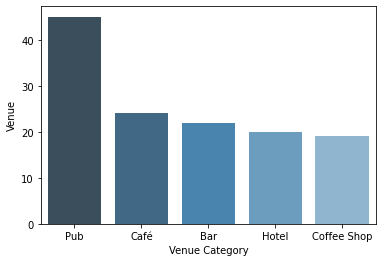

In [14]:
Liver_short_top = Liver_short.sort_values(by=['Venue'], ascending=False)[0:5]
import seaborn as sns
sns.barplot(x="Venue Category", y="Venue", data=Liver_short_top.reset_index(), palette="Blues_d")

In [15]:
Liver_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Liverpool City Centre,14.678012,121.097637,Filinvest 1 Clubhouse,14.681498,121.095315,Club House
1,Liverpool City Centre,14.678012,121.097637,"FILHAI Cooperative Store, Filinvest I",14.681688,121.094703,Grocery Store
2,Liverpool City Centre,14.678012,121.097637,Burger Machine,14.680151,121.091390,Burger Joint
3,Liverpool City Centre,14.678012,121.097637,Filinvest 1 Covered Basketball Court,14.677475,121.089207,Basketball Court
4,Liverpool City Centre,14.678012,121.097637,Filinvest 1 Block 1 Covered Court,14.678945,121.089111,Basketball Court


In [16]:
Liver_venues_count = Liver_venues.groupby('Neighborhood').count().reset_index()
Liver_venues_count[['Neighborhood', 'Venue']]

,Neighborhood,Venue
0,Baltic Triangle,100
1,Belle Vale,15
2,Cantrill Farm,23
3,Cavern Quarter,100
4,Fazakerley,6
5,Fincham,2
6,Georgian Quarter,96
7,Islington,100
8,Knotty Ash,13
9,Knowledge Quarter,100


In [17]:
Liver_venues.shape

(874, 7)

In [18]:
print('There are {} uniques categories.'.format(len(Liver_venues['Venue Category'].unique())))

There are 168 uniques categories.


# Analyze Each Neighborhood

In [19]:
Liver_one_hot = pd.get_dummies(Liver_venues[['Venue Category']], prefix="", prefix_sep="") 

# add neighborhood column back to dataframe
Liver_one_hot['Neighborhood'] = Liver_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Liver_one_hot.columns[-1]] + list(Liver_one_hot.columns[:-1])
Liver_one_hot = Liver_one_hot[fixed_columns]

Liver_one_hot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,...,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Women's Store,Yoga Studio
0,Liverpool City Centre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Liverpool City Centre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Liverpool City Centre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Liverpool City Centre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Liverpool City Centre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
Liver_one_hot.shape

(874, 169)

In [21]:
# Group rows by neighborhood and take the mean as frequency of occurrence of each cateogry.
Liver_grouped = Liver_one_hot.groupby('Neighborhood').mean().reset_index()
Liver_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,...,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Women's Store,Yoga Studio
0,Baltic Triangle,0.00,0.010000,0.00,0.000000,0.00,0.00000,0.00,0.00,0.000000,...,0.000000,0.010000,0.020000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
1,Belle Vale,0.00,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.066667,0.00,0.000000,0.000000,0.00
2,Cantrill Farm,0.00,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
3,Cavern Quarter,0.00,0.010000,0.01,0.010000,0.00,0.00000,0.01,0.00,0.000000,...,0.000000,0.010000,0.010000,0.000000,0.00,0.000000,0.01,0.000000,0.000000,0.00
4,Fazakerley,0.00,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
5,Fincham,0.00,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
6,Georgian Quarter,0.00,0.010417,0.00,0.010417,0.00,0.00000,0.00,0.00,0.000000,...,0.000000,0.010417,0.020833,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
7,Islington,0.01,0.000000,0.00,0.010000,0.02,0.00000,0.00,0.01,0.000000,...,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.00,0.000000,0.000000,0.01
8,Knotty Ash,0.00,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.00,0.076923,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
9,Knowledge Quarter,0.00,0.010000,0.01,0.010000,0.00,0.00000,0.00,0.00,0.000000,...,0.000000,0.010000,0.020000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00


### Print top 5 most common venues from each neighborhood

In [22]:
num_top_venues = 5

for hood in Liver_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Liver_grouped[Liver_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Baltic Triangle----
         venue  freq
0          Bar  0.12
1          Pub  0.08
2  Coffee Shop  0.08
3         Café  0.06
4        Hotel  0.06


----Belle Vale----
                  venue  freq
0           Supermarket  0.13
1  Fast Food Restaurant  0.13
2        Clothing Store  0.13
3                Bakery  0.07
4          Optical Shop  0.07


----Cantrill Farm----
            venue  freq
0     Pizza Place  0.13
1  Sandwich Place  0.09
2  Breakfast Spot  0.04
3        Pharmacy  0.04
4     Gas Station  0.04


----Cavern Quarter----
            venue  freq
0     Coffee Shop  0.09
1           Hotel  0.07
2            Café  0.05
3             Bar  0.05
4  History Museum  0.04


----Fazakerley----
           venue  freq
0    Coffee Shop  0.17
1  Train Station  0.17
2           Café  0.17
3    Golf Course  0.17
4  Grocery Store  0.17


----Fincham----
                venue  freq
0               Hotel   0.5
1  Italian Restaurant   0.5
2                Park   0.0
3         Music Venue  

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Print top 10 venues from each neighborhood

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Liver_grouped['Neighborhood']

for ind in np.arange(Liver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Liver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baltic Triangle,Bar,Coffee Shop,Pub,Café,Hotel,Restaurant,Italian Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Indian Restaurant
1,Belle Vale,Clothing Store,Supermarket,Fast Food Restaurant,Sandwich Place,Warehouse Store,Coffee Shop,Bus Stop,Discount Store,Optical Shop,Bakery
2,Cantrill Farm,Pizza Place,Sandwich Place,Pet Store,Bar,Shopping Mall,Fast Food Restaurant,Breakfast Spot,Coffee Shop,Mediterranean Restaurant,Beer Store
3,Cavern Quarter,Coffee Shop,Hotel,Café,Bar,History Museum,Burger Joint,Pub,Italian Restaurant,Beer Bar,Sandwich Place
4,Fazakerley,Supermarket,Coffee Shop,Grocery Store,Train Station,Golf Course,Café,Diner,Fast Food Restaurant,Farmers Market,English Restaurant
5,Fincham,Hotel,Italian Restaurant,Diner,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
6,Georgian Quarter,Bar,Pub,Coffee Shop,Café,Grocery Store,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Italian Restaurant,Sandwich Place
7,Islington,Pub,French Restaurant,Mediterranean Restaurant,Gastropub,Japanese Restaurant,Bakery,Coffee Shop,Boutique,Fish Market,Cocktail Bar
8,Knotty Ash,Supermarket,Fast Food Restaurant,Chinese Restaurant,Grocery Store,Bus Stop,Sandwich Place,Auto Garage,Sports Club,Pub,Park
9,Knowledge Quarter,Coffee Shop,Bar,Pub,Café,Hotel,Restaurant,Theater,Burger Joint,Cocktail Bar,Comic Shop


# Cluster neighborhoods

In [25]:
# set number of clusters
kclusters = 5

Liver_grouped_clustering = Liver_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Liver_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] 
#Liver_grouped_clustering

array([1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 4, 1, 4, 4, 1, 1, 1, 3, 0, 1, 1],
      dtype=int32)

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Liver_merged = Liver_neighborhood

# merge Liver_grouped with Liver_data to add latitude/longitude for each neighborhood
Liver_merged = Liver_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Liver_merged.head() # check the last columns!
Liver_merged = Liver_merged.dropna()
Liver_merged.head(5)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Liverpool City Centre,14.678012,121.097637,4,Grocery Store,Basketball Court,Club House,Burger Joint,Golf Driving Range,Seafood Restaurant,Yoga Studio,Discount Store,Farmers Market,English Restaurant
1,Liverpool Waterfront,53.602502,-2.843294,1,Café,American Restaurant,Harbor / Marina,Soccer Field,Pub,Train Station,Restaurant,Yoga Studio,English Restaurant,Electronics Store
2,Baltic Triangle,53.395745,-2.980043,1,Bar,Coffee Shop,Pub,Café,Hotel,Restaurant,Italian Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Indian Restaurant
3,Fazakerley,53.468984,-2.936971,1,Supermarket,Coffee Shop,Grocery Store,Train Station,Golf Course,Café,Diner,Fast Food Restaurant,Farmers Market,English Restaurant
4,Norris Green,53.446428,-2.925689,4,Fish & Chips Shop,Warehouse Store,Pharmacy,Park,Discount Store,Diner,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store


In [27]:
Liver_merged.shape

(21, 14)

In [29]:
# create map
map_clusters = folium.Map(location=[latitude_Liverpool, longitude_Liverpool], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Liver_merged['Latitude'], Liver_merged['Longitude'], Liver_merged['Neighborhood'], Liver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

### Let's list all the neightborhood from each cluster

In [30]:
print("Cluster 1")
Liver_merged.loc[Liver_merged['Cluster Labels'] == 0, Liver_merged.columns[[0] + list(range(4, Liver_merged.shape[1]))]]

Cluster 1


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Knotty Ash,Supermarket,Fast Food Restaurant,Chinese Restaurant,Grocery Store,Bus Stop,Sandwich Place,Auto Garage,Sports Club,Pub,Park
20,Swanside,Fast Food Restaurant,Supermarket,Pharmacy,Auto Garage,Grocery Store,Bus Stop,Discount Store,Fish & Chips Shop,Farmers Market,English Restaurant


In [31]:
print("Cluster 2")
Liver_merged.loc[Liver_merged['Cluster Labels'] == 1, Liver_merged.columns[[0] + list(range(4, Liver_merged.shape[1]))]]

Cluster 2


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Liverpool Waterfront,Café,American Restaurant,Harbor / Marina,Soccer Field,Pub,Train Station,Restaurant,Yoga Studio,English Restaurant,Electronics Store
2,Baltic Triangle,Bar,Coffee Shop,Pub,Café,Hotel,Restaurant,Italian Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Indian Restaurant
3,Fazakerley,Supermarket,Coffee Shop,Grocery Store,Train Station,Golf Course,Café,Diner,Fast Food Restaurant,Farmers Market,English Restaurant
5,Belle Vale,Clothing Store,Supermarket,Fast Food Restaurant,Sandwich Place,Warehouse Store,Coffee Shop,Bus Stop,Discount Store,Optical Shop,Bakery
7,Ropewalks,Coffee Shop,Café,Bar,Hotel,Pub,Burger Joint,Beer Bar,Italian Restaurant,Department Store,Caribbean Restaurant
8,Cavern Quarter,Coffee Shop,Hotel,Café,Bar,History Museum,Burger Joint,Pub,Italian Restaurant,Beer Bar,Sandwich Place
9,Georgian Quarter,Bar,Pub,Coffee Shop,Café,Grocery Store,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Italian Restaurant,Sandwich Place
10,Cantrill Farm,Pizza Place,Sandwich Place,Pet Store,Bar,Shopping Mall,Fast Food Restaurant,Breakfast Spot,Coffee Shop,Mediterranean Restaurant,Beer Store
11,St George's Quarter,Coffee Shop,Supermarket,Bar,Café,Pub,Indian Restaurant,Clothing Store,Furniture / Home Store,Tennis Court,Gym
12,Warbreck,Tram Station,Gastropub,Hotel,Pet Store,Casino,Sandwich Place,Beach,Thrift / Vintage Store,Train Station,Pizza Place


In [32]:
print("Cluster 3")
Liver_merged.loc[Liver_merged['Cluster Labels'] == 2, Liver_merged.columns[[0] + list(range(4, Liver_merged.shape[1]))]]

Cluster 3


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Fincham,Hotel,Italian Restaurant,Diner,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


In [33]:
print("Cluster 4")
Liver_merged.loc[Liver_merged['Cluster Labels'] == 3, Liver_merged.columns[[0] + list(range(4, Liver_merged.shape[1]))]]

Cluster 4


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Stanley,Diner,Pub,Grocery Store,Tourist Information Center,Yoga Studio,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Eastern European Restaurant


In [34]:
print("Cluster 5")
Liver_merged.loc[Liver_merged['Cluster Labels'] == 4, Liver_merged.columns[[0] + list(range(4, Liver_merged.shape[1]))]]

Cluster 5


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Liverpool City Centre,Grocery Store,Basketball Court,Club House,Burger Joint,Golf Driving Range,Seafood Restaurant,Yoga Studio,Discount Store,Farmers Market,English Restaurant
4,Norris Green,Fish & Chips Shop,Warehouse Store,Pharmacy,Park,Discount Store,Diner,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store
6,Orrell Park,Pizza Place,Supermarket,Train Station,Pub,Park,Sandwich Place,Discount Store,Pharmacy,Gym / Fitness Center,Grocery Store
